In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -r /content/drive/MyDrive/brain/requirements.txt

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import numpy as np
import pandas as pd

# Update file paths accordingly to access files from your Drive
# For example, if your file is located in 'My Drive/data/'
data_path = '/content/drive/MyDrive/brain/brain__tumor_data'

# Now you can use data_path to access your files
# For example:
# df = pd.read_csv(data_path + 'filename.csv')

# Your code for data processing, analysis, or machine learning goes here


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG19

from warnings import filterwarnings
filterwarnings('ignore')

import random

import glob
from IPython.display import display

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/brain/brain_data_csv/metadata.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4600 non-null   int64 
 1   image       4600 non-null   object
 2   class       4600 non-null   object
 3   format      4600 non-null   object
 4   mode        4600 non-null   object
 5   shape       4600 non-null   object
dtypes: int64(1), object(5)
memory usage: 215.8+ KB


In [ ]:
data.head(10)

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"
5,5,Cancer (100).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
6,6,Cancer (1000).jpg,tumor,JPEG,RGB,"(290, 250, 3)"
7,7,Cancer (1001).jpg,tumor,JPEG,RGB,"(620, 620, 3)"
8,8,Cancer (1002).JPG,tumor,JPEG,RGB,"(338, 264, 3)"
9,9,Cancer (1003).jpg,tumor,JPEG,RGB,"(442, 353, 3)"


In [ ]:
import os

data_map = []
# Iterate through the directories and files in "/content/drive/MyDrive/brain__tumor_data"
for sub_dir_path in os.scandir("/content/drive/MyDrive/brain/brain__tumor_data/lgg-mri-segmentation/kaggle_3m"):
    try:
        # Get the name of the current directory
        dir_name = sub_dir_path.name
        # Check if the item is a directory
        if sub_dir_path.is_dir():
            # Iterate through the files in the current directory
            for filename in os.listdir(sub_dir_path.path):
                # Construct the full path to the image file
                image_path = os.path.join(sub_dir_path.path, filename)
                # Append the directory name and image path to the data_map list
                data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)


In [ ]:
brain_df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
brain_df.tail()

,patient_id,path
7857,TCGA_CS_4941_19960909,/content/drive/MyDrive/brain/brain__tumor_data...
7858,123,/content/drive/MyDrive/brain/brain__tumor_data...
7859,123,/content/drive/MyDrive/brain/brain__tumor_data...
7860,123,/content/drive/MyDrive/brain/brain__tumor_data...
7861,123,/content/drive/MyDrive/brain/brain__tumor_data...


In [ ]:
import numpy as np
import pandas as pd
import os
import re
import random

# Define a DataFrame 'brain_df' with columns 'patient_id' and 'path'
brain_df = pd.DataFrame({"patient_id": data_map[::2],
                         "path": data_map[1::2]})

# Define sorting function with regular expression
def is_mask(filename):
    match = re.search(r'\d_mask', filename)
    if match:
        return int(match.group())
    else:
        return float('inf')  # Handle cases where no numeric part is found

# Sort images and masks
imgs = sorted(brain_df["path"].values, key=lambda x: extract_number(x))
masks = sorted(brain_df["path"].values, key=lambda x: extract_number(x))

# Check a random pair of paths
idx = random.randint(0, len(imgs) - 1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])


NameError: name 'extract_number' is not defined

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import random

img_path = []
mask_path = []
temp = brain_df['path'].values

for i in range(len(temp)):
  match = re.search(r'\d_mask', str(temp[i]))
  if match:
    elem = str(temp[i])
    img_path.append(elem[:-9]+str(".tif"))
  else:
    mask_path.append(str(temp[i]))

In [ ]:
print("Length of the array img_path is {} and mask_path is {}".format(len(img_path), len(mask_path)))

Length of the array img_path is 3929 and mask_path is 3929


In [ ]:
df = pd.DataFrame({
    "image_paths":sorted(img_path),
    "mask_paths" :sorted(mask_path)
})
df.head(10)

,image_paths,mask_paths
0,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...
1,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...
2,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...
3,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...
4,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...
5,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...
6,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...
7,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...
8,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...
9,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 1],
        [0, 0, 2],
        [0, 0, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 1],
        [0, 0, 2],
        [0, 0, 1]],

       ...,

       [[0, 0, 2],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [1, 0, 1],
        [1, 0, 1],
        [1, 0, 1]],

       [[0, 0, 2],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [0, 0, 2],
        [0, 0, 1],
        [0, 0, 1]],

       [[0, 0, 2],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]]], dtype=uint8)
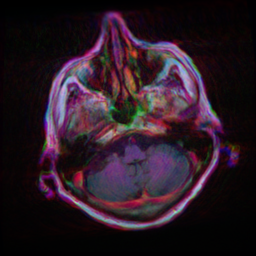

In [ ]:
int_ = random.randint(0,len(df))
val = cv2.imread(df.mask_paths[int_])
val

In [ ]:
def pos_neg_diagnosis(mask_path):
    mask_path = mask_path[:-4]+str("_mask.tif")
    value = np.max(cv2.imread(mask_path))
    if value > 0 :
        return 1
    else:
        return 0

df['mask'] = df['mask_paths'].apply(lambda x: pos_neg_diagnosis(x))
df

,image_paths,mask_paths,mask
0,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...,0
1,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...,0
2,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...,1
3,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...,1
4,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...,1
...,...,...,...
3924,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...,0
3925,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...,0
3926,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...,0
3927,/content/drive/MyDrive/brain/brain__tumor_data...,/content/drive/MyDrive/brain/brain__tumor_data...,0


In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize=(20, 50))
for index, row in df.iterrows():
    if row['mask'] == 1:
        img = io.imread(row['image_paths'])
        axs[count][0].set_title("Brain MRI")
        axs[count][0].imshow(img)
        mask = io.imread(row['mask_paths'])
        axs[count][1].set_title("Mask")
        axs[count][1].imshow(mask, cmap='gray')

        # Convert the mask to single-channel binary mask
        binary_mask = (mask > 0).astype(np.uint8) * 255

        # Apply color directly to the image where mask is non-zero
        img[mask==255] = (255,0,0)
        axs[count][2].set_title("MRI with Mask")
        axs[count][2].imshow(img)

        count += 1
    if count == 12:
        break

fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_mask = df[df['mask'] == 1]
df_mask.shape

NameError: name 'df' is not defined

In [ ]:
# creating test, train and val sets
X_train, X_val = train_test_split(df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_paths)
train_mask = list(X_train.mask_paths)

val_ids = list(X_val.image_paths)
val_mask= list(X_val.mask_paths)

NameError: name 'df_mask' is not defined

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'

    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth)
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])

      #mask path
      mask_path = str(list_mask[i])

      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)

      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising
      img -= img.mean()
      img /= img.std()

      mask -= mask.mean()
      mask /= mask.std()

      #Adding image to the empty array
      X[i,] = img

      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)

    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

NameError: name 'train_ids' is not defined

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output
    s2 = vgg19.get_layer("block2_conv2").output
    s3 = vgg19.get_layer("block3_conv4").output
    s4 = vgg19.get_layer("block4_conv4").output

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

model = build_vgg19_unet((256,256,3))
model.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                       

In [ ]:
# Define a custom loss function for Vgg19 UNet model

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [ ]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model.compile(optimizer = adam,
                  loss = focal_tversky,
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=30
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="seg_model.h5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
history = model.fit(train_data,
                  epochs = 50,
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr],
                  verbose = True
                 )

NameError: name 'train_data' is not defined

In [ ]:
model = load_model("/content/drive/MyDrive/brain/model/seg_model.h5",custom_objects={"focal_tversky":focal_tversky,"tversky":tversky,"tversky_loss":tversky_loss})

In [ ]:
def predict_test(img_path):
  # Specify the path of the test image

  # Load the test image
  img = cv2.imread(img_path)

  # Preprocess the test image (if necessary)
  # For example: resize, normalize, etc.
  # Assuming no preprocessing is needed for now
  # Make prediction using your model

  img = cv2.resize(img,(256,256))
  img = np.array(img,dtype=np.float64)
  img-= img.mean()
  img/= img.std()

  predicted_mask = model.predict(np.expand_dims(img, axis=0))

  # Postprocess the predicted mask (if necessary)
  # For example: thresholding, smoothing, etc.
  # Assuming no postprocessing is needed for now

  # Overlay the predicted mask on the test image
  test_image_with_mask = np.copy(img)
  test_image_with_mask[predicted_mask.squeeze() == 1] = [255,0,0]  # Green color for the mask

  # Plot the original test image and the image with the predicted mask
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.title('Original Test Image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(test_image_with_mask)
  plt.title('Test Image with Predicted Mask')
  plt.axis('off')

  plt.show()

1/1 [==============================] - 0s 43ms/step


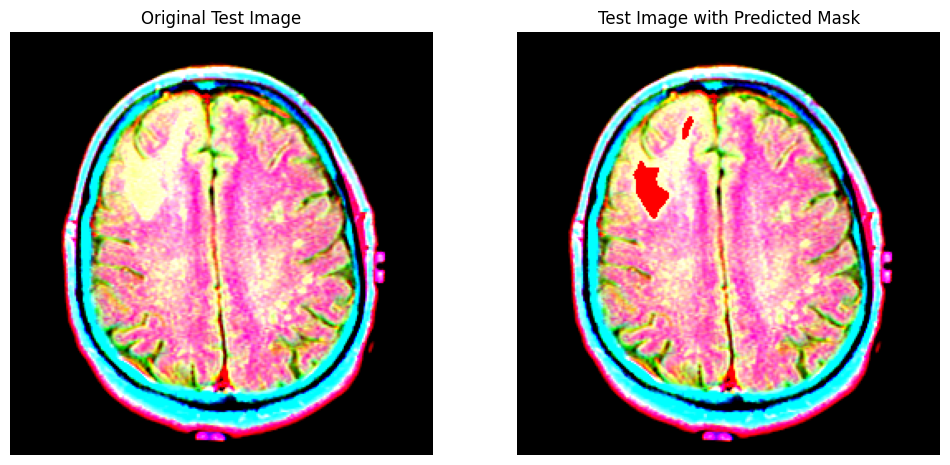

In [ ]:
predict_test('/content/drive/MyDrive/brain/brain__tumor_data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif')

In [ ]:
history.history.keys()

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['tversky']);
plt.plot(history.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)

In [ ]:
def prediction(test, model_seg):

    # empty list to store results
    mask, image_id,has_mask = [], [], []

    #itetrating through each image in test data
    for i in test.image_path:



        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)

        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img

        #make prediction of mask
        predict = model_seg.predict(X)

        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)

    return pd.DataFrame({'image_path': image_id, 'image':'predicted_mask': mask,'has_mask': has_mask})

In [ ]:
# making prediction
df_pred = prediction(X_test, model)
df_pred

In [ ]:
# merging original and prediction df
df_pred = X_test.merge(df_pred, on='image_path')
df_pred.head(10)

In [ ]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')

        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')

        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')

        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')

        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')

        count +=1
    if (count==15):
        break

fig.tight_layout()

In [ ]:
# Save the entire model to a single HDF5 file
model.save("vgg.h5")


In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

# Define the custom loss function
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.7
    return (true_pos + 1) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + 1)

def focal_tversky(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1 - pt_1), gamma)

# Register the custom loss and metric functions
tf.keras.utils.get_custom_objects()['focal_tversky'] = focal_tversky
tf.keras.utils.get_custom_objects()['tversky'] = tversky

# Now you can load the model and use the predict_single_image function
import matplotlib.pyplot as plt
import numpy as np

def predict_single_image(image_path, model_path):
    # Load the model
    model = tf.keras.models.load_model(model_path, compile=False)

    # Read the image
    img = io.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img = np.array(img, dtype=np.float64)
    img -= img.mean()
    img /= img.std()
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction of mask
    predicted_mask = model.predict(img)

    # Visualize the input image and predicted mask
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(io.imread(image_path))
    plt.title('Input Image')

    plt.subplot(1, 2, 2)
    predicted_mask = predicted_mask.squeeze().round()
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

# Example usage:
image_path_to_predict = '/content/tum.jpg'
model_path = '/content/vgg.h5'
predict_single_image(image_path_to_predict, model_path)
